# **Linkedin Jobs Scrapping**
In this project, I will scrape job posting data from LinkedIn. The goal is to be more prepared to land my first job as a intern in the data world.

I want to see the location of the internship jobs and the requirements. Sadly, in Europe is not common to publish salary data, but I will also check the salaries of my -hopefully- first junior position. 

To achieve this, I will set up the environment, identify the job posting site, scrape the data, process, analyze, and visualize the data.

Let's do it!

### Step 1: Understanding the LinkedIn Jobs Search Page

A quick inspection to the search page throws at us certain inconveniences:
- The list of jobs are in individual cards with little information: company name, job name, location, and some extra info, like job id and link to the job post. So not everything is in one page.
- It has **lazy load**. LinkedIn only loads the first 35 jobs at first. You need to scroll to the bottom of the page to load the next 25 jobs. 
- After 5 times lazyloading, a **'see more jobs'** button will pop up. 

Let's first solve the last two problems. **How can I load all the jobs in a search?**

### Step 2: Scroll down and click with Selenium

**Selenium** is a python library that automates browsers. So, basically, it will open a chrome tab and scroll down and click in the 'see more jobs' button for us.  

In [2]:
#Import Packages
from selenium import webdriver
import time
import pandas as pd
import os

from selenium.webdriver.support.select import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service

In [3]:
#This code below opens a chrome window in the referenced url
#Setting webdriver 
service = Service(executable_path=r'D:\\DATA\\Projects\\Linkedin-Jobs-Scrapping\\chromedriver-win64\\chromedriver.exe')
driver = webdriver.Chrome(service=service)
#The url we want to open. Later in the process we will make this url dynamic. 
url1 = 'https://www.linkedin.com/jobs/search/?keywords=Data&location=Spain&geoId=105646813&f_TPR=&f_E=1&position=1'
driver.get(url1) #open the job search page
driver.implicitly_wait(10) #for safety, wait 10 segs to give time to load completely 

In [24]:
#Find number of jobs in the search

n = driver.find_element(By.CLASS_NAME, 'results-context-header__job-count').text
#Because LinkedIn writes '+17,700', we have to deal with any symbols to convert the number to an int.
n = n.rstrip("+")
n = int(n.replace(",", ""))
y=pd.to_numeric(n)
y

612

In [ ]:
#Scrolling down and loading all jobs 
i = 0
while i <= int((y+35+25)/25): 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    i = i + 1
    print('number of jobs:', 35+i*25)
    
    try:
        driver.find_element(By.XPATH,'//*[@id="main-content"]/section[2]/button').click()
        time.sleep(1)
            
    except:
        pass
        time.sleep(2)
         

###  Step 3: Extracting the data from the job list

Now that we have all the job cards loaded. Let's get their info! 

In [10]:
#Let's initiate some lists
CompanyName = []
JobTitle= []

In [26]:
#testing the code
driver.find_elements(By.CLASS_NAME, 'base-search-card__subtitle')[116].text

'Emerald Stay® (A certified B Corp)'

In [27]:
#Loop to go through all jobs and extract their data
for job in range(y):
    company = driver.find_elements(By.CLASS_NAME, 'base-search-card__subtitle')[job].text
    CompanyName.append(company)

CompanyName

IndexError: list index out of range

Here, I encountered a `IndexError: list index out of range` all the time. 

I checked more deeply how linkedIn loads their jobs and how the page look. After several attempts and searches, I figured out that linkedIn never shows the full list of available jobs.

If your search job number is an inexact number (+17,000, for example), the page stops loading more jobs after several clicks on the button. 

If your search is an exact number, you can reach the 'You've viewed all jobs for this search' tag. But it is a bit deceitful. If you inspect their code, the last card is even referenced as the last number of your search. That is, if you had 617 jobs, you will see a div with the class: `data-row="610"`. But actually they had been skipping numbers all the time. So out of a search of 600, they usually show half of them: 300.

This could be good enough. But we are learning here. So I decided to try a different method. 

### Step 2b: using Scrapy + ScrapeOps proxy aggregator [Abandoned]

After a good while trying this method to function (https://www.youtube.com/watch?v=d4iz2NrZVRg&ab_channel=ScrapeOps), I gave up. LinkedIn automatically detected those calls and blocked them throwing a 403 error.

###  Step 3: Extracting the data from the job list (continuation)

After some more research, it seems that scraping LinkedIn is quite difficult, and that it might get you banned if they caught you doing it. We will have to try again using selenium. 

In [82]:
#This code below opens a chrome window in the referenced url
#Setting webdriver 
service = Service(executable_path=r'D:\\DATA\\Projects\\Linkedin-Jobs-Scrapping\\chromedriver-win64\\chromedriver.exe')
driver = webdriver.Chrome(service=service)
#The url we want to open. Later in the process we will make this url dynamic. 
url1 = 'https://www.linkedin.com/jobs/search/?keywords=Data&location=Spain&geoId=105646813&f_TPR=&f_E=1&position=1'
driver.get(url1) #open the job search page
driver.implicitly_wait(10) #for safety, wait 10 segs to give time to load completely 

In [83]:
# Scroll down and load all jobs. I changed a bit the loop since we couldn't rely anymore on the n provided by LinkedIn. 
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # wait for new jobs to load

    try:
        # Click the "See more jobs" button if it exists
        see_more_button = driver.find_element(By.XPATH, '//*[@id="main-content"]/section[2]/button')
        see_more_button.click()
        time.sleep(2)  # wait for jobs to load after clicking the button
    except:
        pass

    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

In [84]:
# In the same way, we had to find a dynamic way to set the range in which to loop our function. 
# Let's find how many job cards there are loaded.
job_list = driver.find_element(By.CLASS_NAME, 'jobs-search__results-list')
job_cards = job_list.find_elements(By.TAG_NAME, 'li')

len(job_cards)

300

In [ ]:
#Let's initiate some lists
CompanyName = []
JobTitle= []
place = []
posted_date = []
urlPost = []
# Let's iterate through all the cards to extract some data: 
j = 0
for job_card in job_cards:
    try:
        company = job_card.find_element(By.CLASS_NAME, 'base-search-card__subtitle').text
        title = job_card.find_element(By.CLASS_NAME, 'base-search-card__title').text
        location = job_card.find_element(By.CLASS_NAME, 'job-search-card__location').text
        date = job_card.find_element(By.XPATH, './/time[contains(@class, "job-search-card__listdate")]').get_attribute('datetime')
        linkPost = job_card.find_element(By.CLASS_NAME, 'base-card__full-link').get_attribute('href')
        
        CompanyName.append(company)
        JobTitle.append(title)
        place.append(location)
        urlPost.append(linkPost)
        posted_date.append(date)
        
        j = j+1
        print('Jobs extracted: ', j,linkPost)

    except Exception as e:
        print(f"Error extracting data from a job card: {e}")
        pass

# Print extracted data
data = {
    'Company Name': CompanyName,
    'Job Title': JobTitle,
    'location': place,
    'Job URL': urlPost,
    'Date' : posted_date
}
jobs_df = pd.DataFrame(data)
jobs_df.to_csv("first_attempt_jobs.csv")

In [50]:
#Now, we need to use our list of url to access them one by one and fetch the job description, and some other info
applicants = []
experience = []
typeEmploy = []
description = []
sector = []

service = Service(executable_path=r'D:\\DATA\\Projects\\Linkedin-Jobs-Scrapping\\chromedriver-win64\\chromedriver.exe')
driver = webdriver.Chrome(service=service)

for link in jobs_df['Job URL']:
    #This code below opens a chrome window in the referenced url
    #Setting webdriver 
    driver.get(link) #open the job page
    driver.implicitly_wait(4) #for safety, wait 4 segs to give time to load completely 

    try:
            # Click the "See more jobs" button if it exists
            show_more_button = driver.find_element(By.CLASS_NAME, 'show-more-less-html__button')
            show_more_button.click()
            time.sleep(2)  # wait for jobs to load after clicking the button
    except:
            pass

    num_applicants = driver.find_element(By.CLASS_NAME, 'num-applicants__caption').text.replace(' applicants', '').strip()
    experience_level = driver.find_element(By.XPATH, './/ul[contains(@class, "description__job-criteria-list")]/li[1]/span').text
    employment_type = driver.find_element(By.XPATH, './/ul[contains(@class, "description__job-criteria-list")]/li[2]/span').text
    sector_type = driver.find_element(By.XPATH, './/ul[contains(@class, "description__job-criteria-list")]/li[4]/span').text
    desc = driver.find_element(By.CLASS_NAME, 'description__text').text
    time.sleep(2)


    applicants.append(num_applicants)
    experience.append(experience_level)
    typeEmploy.append(employment_type)
    sector.append(sector_type)
    description.append(desc)
    
applicants


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":".num-applicants__caption"}
  (Session info: chrome=125.0.6422.141); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7BB2E1F52+60322]
	(No symbol) [0x00007FF7BB25CEC9]
	(No symbol) [0x00007FF7BB117EBA]
	(No symbol) [0x00007FF7BB167676]
	(No symbol) [0x00007FF7BB16773C]
	(No symbol) [0x00007FF7BB1AE967]
	(No symbol) [0x00007FF7BB18C25F]
	(No symbol) [0x00007FF7BB1ABC80]
	(No symbol) [0x00007FF7BB18BFC3]
	(No symbol) [0x00007FF7BB159617]
	(No symbol) [0x00007FF7BB15A211]
	GetHandleVerifier [0x00007FF7BB5F94AD+3301629]
	GetHandleVerifier [0x00007FF7BB6436D3+3605283]
	GetHandleVerifier [0x00007FF7BB639450+3563680]
	GetHandleVerifier [0x00007FF7BB394326+790390]
	(No symbol) [0x00007FF7BB26750F]
	(No symbol) [0x00007FF7BB263404]
	(No symbol) [0x00007FF7BB263592]
	(No symbol) [0x00007FF7BB252F9F]
	BaseThreadInitThunk [0x00007FFF1E557344+20]
	RtlUserThreadStart [0x00007FFF205626B1+33]


Well, this method was caught by the LinkedIn anti-bots systems. The spider was blocked after the third of forth window open in a row.

### Step 3.2 Trying anti-bot methods 

Luckily, there are enough tools out there to fake the behavior of a real user:
- random waiting times: mimics human behavior 
- using several random fake users: the requests come from different users, so it is less suspicious.

In [ ]:
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd

# Load the DataFrame with job URLs
jobs_df = pd.read_csv('first_attempt_jobs.csv')

# Initialize lists to store the extracted data
applicants = []
experience = []
typeEmploy = []
description = []
sector = []

# Setting WebDriver with Options. These reduce the chances of getting detected by the anti-bot LinkedIn's systems. 
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run headless for less detection (remove this if you want to see the browser)
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
# chrome_options.add_argument("start-maximized")
chrome_options.add_argument("--disable-infobars")
chrome_options.add_argument("--disable-extensions")

# Add a random user-agent. Every time we launch Chrome, it will use a random fake user out of those 5. There is more  efficient ways of doing this. But this was enough. 
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36",
]
chrome_options.add_argument(f"user-agent={random.choice(user_agents)}")

service = Service(executable_path=r'D:\\DATA\\Projects\\Linkedin-Jobs-Scrapping\\chromedriver-win64\\chromedriver.exe')
driver = webdriver.Chrome(service=service, options=chrome_options)
j=1

for link in jobs_df['Job URL']:
    driver.get(link)  # open the job page
    time.sleep(random.uniform(2, 3))  # wait for the page to load completely with a random delay

    try:
        # Click the "See more jobs" button if it exists
        show_more_button = driver.find_element(By.CLASS_NAME, 'show-more-less-html__button')
        show_more_button.click()
        time.sleep(random.uniform(2, 4))  # wait for the additional content to load with a random delay
    except:
        pass

    try:
        num_applicants = driver.find_element(By.CLASS_NAME, 'num-applicants__caption').text.replace(' applicants', '').strip()
    except:
        num_applicants = 'N/A'
        
    try:
        experience_level = driver.find_element(By.XPATH, './/ul[contains(@class, "description__job-criteria-list")]/li[1]/span').text
    except:
        experience_level = 'N/A'
    
    try:
        employment_type = driver.find_element(By.XPATH, './/ul[contains(@class, "description__job-criteria-list")]/li[2]/span').text
    except:
        employment_type = 'N/A'
    
    try:
        sector_type = driver.find_element(By.XPATH, './/ul[contains(@class, "description__job-criteria-list")]/li[4]/span').text
    except:
        sector_type = 'N/A'
    
    try:
        desc = driver.find_element(By.CLASS_NAME, 'description__text').text
    except:
        desc = 'N/A'

    applicants.append(num_applicants)
    experience.append(experience_level)
    typeEmploy.append(employment_type)
    sector.append(sector_type)
    description.append(desc)

    print(j, ": ", desc[:15])
    j = j+1

    # Random sleep to mimic human behavior
    time.sleep(random.uniform(1, 3))

# Close the WebDriver
driver.quit()

# Create a DataFrame from the lists
data_plus = {
    'Company Name': jobs_df['Company Name'],
    'Job Title': jobs_df['Job Title'],
    'location': jobs_df['location'],
    'Job URL': jobs_df['Job URL'],
    'Date': jobs_df['Date'],
    'Applicants': applicants,
    'Experience': experience,
    'Employment Type': typeEmploy,
    'Sector': sector,
    'Description': description
}
detailed_jobs_df = pd.DataFrame(data_plus)


# Print the DataFrame to verify
# detailed_jobs_df.to_csv('detailed_jobs_df.csv')


### Step 4: Preparing the data

- right format data
- cleaning null values
- Preparing the description text for different algorithms
- Cleaning the applicants column

In [267]:
# Let's fix some columns and formats. 
detailed_jobs_df = detailed_jobs_df.drop(columns='Unnamed: 0')
detailed_jobs_df['Date'] = pd.to_datetime(detailed_jobs_df['Date'])



Let's clean up the Applicants column to extract only the number out of the string. It is not simply removing 'solicitudes', it changes in language and form. 

In [371]:
detailed_jobs_df['Applicants']

0                         135 solicitudes
1                          29 solicitudes
2                         100 solicitudes
3                          70 solicitudes
4                         125 solicitudes
                      ...                
293                       163 solicitudes
294                        43 solicitudes
295                        82 solicitudes
296    Sé de los primeros 25 solicitantes
297    Sé de los primeros 25 solicitantes
Name: Applicants, Length: 298, dtype: object

In [372]:
def extract_number(string):
    for i in string.split():
        if i.isdigit():
            return int(i)

In [374]:
detailed_jobs_df['Applicants'] = detailed_jobs_df['Applicants'].apply(extract_number)

In [376]:
detailed_jobs_df.to_csv('detailed_jobs_with_keywords.csv')

### Step 5: Adding Language and skills columns with ML 
We wil detect the language in which the description has been written. This will be helpful later, but also as a metric. In which languages are the job offers?

In [265]:
import pandas as pd

detailed_jobs_df = pd.read_csv('detailed_jobs_df.csv')

In [266]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

detailed_jobs_df['language'] = detailed_jobs_df['Description'].apply(detect_language)

detailed_jobs_df['language'].value_counts()

language
en    238
es     57
fr      2
ca      1
Name: count, dtype: int64

In [6]:
detailed_jobs_df['Date'][4]

Timestamp('2024-06-05 00:00:00')

In [268]:
detailed_jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Company Name     298 non-null    object        
 1   Job Title        298 non-null    object        
 2   location         298 non-null    object        
 3   Job URL          298 non-null    object        
 4   Date             298 non-null    datetime64[ns]
 5   Applicants       298 non-null    object        
 6   Experience       298 non-null    object        
 7   Employment Type  287 non-null    object        
 8   Sector           287 non-null    object        
 9   Description      298 non-null    object        
 10  language         298 non-null    object        
dtypes: datetime64[ns](1), object(10)
memory usage: 25.7+ KB


### Step5b: Keywords extraction trying numerous methods

We will use different libraries and methods to increase the accuracy of our keyword extraction model. 

#### Step 5b Preprocessing the text

In many tutorials and examples they recommend to clean up the text. For example, by removing stop words (words without meaning but that are grammatically important.) This proved to be futile since we ended up using a system that relied on exactly the position and grammar function of the words to derive importance. But we didn't know!

In [ ]:
text = detailed_jobs_df['Description'][2]

In [362]:
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [32]:
text = clean_text(text)

text

'job summary data analytics trainee embark journey dive deep world data science analytics role designed individuals passionate leveraging data drive insights make informed decisions part dynamic team data professionals working closely experienced data analysts bi analysts data engineers hone skills contribute realworld projects key accountabilities among others analytical support assist data collection cleaning preprocessing tasks guidance senior team members learn navigate manipulate data using programming languages python sql follow established protocols ensure data quality integrity throughout process contribute basic data analysis tasks descriptive statistics exploratory data analysis hypothesis testing visualization reporting assist creating visualizations dashboards communicate data findings effectively learn use data visualization tools libraries create clear compelling presentations analytical results minimum knowledge experience required position expect experience knowledge pr

#### Step 5b Trying Yake
Let's try Yake first. Yake is an unsupervised approach for automatic keyword extraction using Text Features. It does not need to be trained on a particular set of documents, neither it depends on dictionaries, external-corpus, size of the text, language or domain.

In [33]:
import yake


In [67]:
# Specify YAKE! parameters
# Initialize keyword extractor
kw_extractor = yake.KeywordExtractor()

language = "en"
max_ngram_size = 3
deduplication_thresold = 0.2
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 15

kw_extractor = yake.KeywordExtractor(lan=language, 
                                     n=max_ngram_size, 
                                     dedupLim=deduplication_thresold, 
                                     dedupFunc=deduplication_algo, 
                                     windowsSize=windowSize, 
                                     top=numOfKeywords)
                                            
keywords = kw_extractor.extract_keywords(text)

for kw in keywords:
    print(kw)

('analysis python sql', 0.0003481795085190169)
('visualization tools libraries', 0.00040594074697135443)
('knowledge programming languages', 0.0004132641754345171)
('techniques knowledge visualization', 0.00045232687292902374)
('expect experience knowledge', 0.000508473785199765)
('work completed efficiently', 0.0005142173288362012)
('contribute realworld projects', 0.0005144422774514619)
('relationships accurately perceiving', 0.0005144422774514619)
('journey dive deep', 0.0005269183373426173)
('data', 0.006146915416871837)
('skill job', 0.006181151999150864)
('job summary', 0.006332958467500928)
('learning', 0.019838363480312465)
('results', 0.026120500979977437)
('work', 0.026120500979977437)


#### Step 5b Trying Rake

Rake is another unsupervised method that tries to determine key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. 

Because our texts are not that long, Yake didn't yield good results.

Let's try another unsupervised one.

In [61]:
import RAKE
import operator

# Reka setup with stopword directory
stop_dir = "SmartStoplist.txt"
rake_object = RAKE.Rake(stop_dir)

# Extract keywords
keywords = rake_object.run(text)
keywords

[('role designed individuals passionate leveraging', 25.0),
 ('integrity throughout process contribute basic', 25.0),
 ('experience required position expect experience', 25.0),
 ('trainee embark journey dive', 16.0),
 ('professionals working closely experienced', 16.0),
 ('follow established protocols ensure', 16.0),
 ('actively identifying new areas', 16.0),
 ('regularly creating taking advantage', 15.5),
 ('opportunities using newly gained', 14.5),
 ('assist creating visualizations', 8.5),
 ('languages commonly used', 8.0),
 ('job summary', 4.0),
 ('navigate manipulate', 4.0),
 ('tasks descriptive', 4.0),
 ('findings effectively', 4.0),
 ('principles techniques', 4.0),
 ('skill job', 4.0),
 ('show less', 4.0),
 ('using', 2.5),
 ('assist', 2.0),
 ('languages', 2.0),
 ('world', 1.0),
 ('analysts', 1.0),
 ('collection', 1.0),
 ('exploratory', 1.0),
 ('communicate', 1.0),
 ('use', 1.0),
 ('manipulation', 1.0),
 ('familiarity', 1.0),
 ('like', 1.0)]

Neither Yake or Rake yielded good results. Let's try with more complex scenarios.

#### Step 5b using spaCy for Named Entity Recognition (NER)
spaCy is a powerful NLP library that can be used to extract named entities and potentially extend this to custom entities like specific skills from job descriptions. 

In [217]:
text2 = detailed_jobs_df['Description'][2]

In [218]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Process text
doc = nlp(text2)

# Extract entities
for ent in doc.ents:
    print(ent.text, ent.label_)


Job Summary PERSON
Analytics Trainee PERSON
BI ORG
Key Accountabilities LOC
Analytical Support
Assist PERSON
Learn PRODUCT
SQL ORG
Contribute ORG
Visualization and Reporting:
Assist WORK_OF_ART
Learn PRODUCT
Minimum Knowledge & Experience ORG
SQL ORG
Power BI ORG
QlikSense ORG
Clear GPE
English LANGUAGE
English LANGUAGE
Managing Work
Effectively WORK_OF_ART
Emotional Intelligence Essentials
Establishing ORG
Building Partnerships
Developing WORK_OF_ART
Continuous Improvement
 PERSON
Continuous Learning PERSON


#### Step 5b trying KeyBERT for Dynamic Keyword Extraction
KeyBERT uses BERT embeddings to extract keywords that are contextually important. Unlike fixed lists or simple matching, KeyBERT understands the context and semantics of words in text.


In [60]:
from keybert import KeyBERT

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(text)

print(keywords)


[('competencies', 0.3771), ('skills', 0.3655), ('tasks', 0.363), ('insights', 0.3176), ('analytics', 0.3005)]


#### Step 5c Tuning SpaCy
SpaCy has been the best performer by far. But it'd be nice to tune it a bit to improve its results even further. We are going to use a list of 238 data skills to guide the extraction. This list will be a guide. Meaning: all words in list will be consider keywords, but will not be limited to those. 


In [99]:
#This was the first attempt
from spacy.pipeline import EntityRuler

# Load your spaCy model
nlp = spacy.load("en_core_web_lg")

# Create the EntityRuler
ruler = nlp.add_pipe("entity_ruler", before="ner", config={"overwrite_ents": True})

# Example list of skills/keywords
with open("DataSkills.txt", 'r') as file:
    skills = file.readlines()
skills = [skill.strip() for skill in skills]

# Create patterns to add to the ruler
patterns = [{"label": "SKILL", "pattern": skill} for skill in skills]
ruler.add_patterns(patterns)

text = detailed_jobs_df['Description'][130]
doc = nlp(text)

# Test the updated pipeline
for ent in doc.ents:
    print(ent.text, ent.label_)

Big Data ORG
Media & Digital Publishers ORG
Spanish NORP
Communication ORG
the Marketing department ORG
Big Data ORG
Communication ORG
Italian NORP
Spanish LANGUAGE
Humanity, Social sciences ORG
Communication/Information sciences ORG
3 months DATE
500€/month CARDINAL
Internship Hours EVENT
Monday to Friday DATE
10 to 19 hours TIME
Madrid GPE
NIE ORG
Madrid Holidays ORG
Madrid GPE
300 - 600 euros MONEY
One CARDINAL
550 - 990 euros MONEY
1 month DATE
30 - 40 euros MONEY
10 - 12 euros MONEY
2 CARDINAL
40 euros MONEY
1 CARDINAL
6 euros MONEY
500 grams QUANTITY
3,11 euros MONEY
500 grams QUANTITY
4,87 euros MONEY
1 kg QUANTITY
1,00 euro MONEY
1 kg QUANTITY
1,80 euros MONEY
1 CARDINAL
euros

Transportation ORG
1 liter QUANTITY
1,30 euros MONEY
monthly DATE
55 euros MONEY
1,17 euros

Transportation MONEY
9 euros MONEY
9 euros MONEY
2 CARDINAL
between 30 - 40 euros CARDINAL
1-month DATE
between 35 - 50 euros CARDINAL
Madrid GPE
the season DATE
Madrid GPE
winters DATE
the winter months DATE
Nov

Tuning the ruler with our list of skills, it yields considerable better results. Let's now apply this code to all descriptions 

In [111]:
from spacy.pipeline import EntityRuler
#Setting the model
nlp = spacy.load("en_core_web_lg")
ruler = nlp.add_pipe("entity_ruler", before="ner", config={"overwrite_ents": True})

with open("DataSkills.txt", 'r') as file:
    skills = file.readlines()
skills = [skill.strip() for skill in skills]

patterns = [{"label": "SKILL", "pattern": skill} for skill in skills]
ruler.add_patterns(patterns)

#initiate function: 
def extract_keywords(description):
    doc = nlp(description)
    keywords = [ent.text for ent in doc.ents if ent.label_ == 'SKILL']
    return keywords

In [112]:
# Apply the function to the 'Description' column and create a new 'keywords' column
detailed_jobs_df['keywords'] = detailed_jobs_df['Description'].apply(extract_keywords)

detailed_jobs_df['keywords']

0                                          [Python, SQL]
1                                          [Python, SQL]
2      [data science, analytics, Python, SQL, data qu...
3      [AWS, Azure, AWS Lambda, Kubernetes, AWS, AWS,...
4                                                     []
                             ...                        
293                          [analytics, Python, Python]
294                                                   []
295                                                   []
296                                                 [AI]
297    [reporting, reporting, big data, reporting, re...
Name: keywords, Length: 298, dtype: object

Here I remember that the descriptions are in different languages. So after many attempts to fix it. I decided to go the easy route and translate them before running them through the English model of spaCy. 

In [126]:
#Attempting to deal the multiple languages 
import spacy
from spacy.pipeline import EntityRuler
import pandas as pd

# Load your spaCy models for different languages
nlp_en = spacy.load("en_core_news_lg")
nlp_es = spacy.load("es_core_news_lg")
nlp_fr = spacy.load("fr_core_news_lg")
nlp_ca = spacy.load("ca_core_news_lg")
nlp_nl = spacy.load("nl_core_news_lg")
nlp_de = spacy.load("de_core_news_lg")

# Create the EntityRuler for each model
def create_entity_ruler(nlp, skills):
    ruler = EntityRuler(nlp, overwrite_ents=True)
    patterns = [{"label": "SKILL", "pattern": skill} for skill in skills]
    ruler.add_patterns(patterns)
    nlp.add_pipe(ruler, before="ner")
    return nlp

# Read the list of skills from the text file
with open("DataSkills.txt", 'r') as file:
    skills = file.readlines()
skills = [skill.strip() for skill in skills]

# Add EntityRuler to each model
nlp_en = create_entity_ruler(nlp_en, skills)
nlp_es = create_entity_ruler(nlp_es, skills)
nlp_e = create_entity_ruler(nlp_es, skills)


ValueError: [E966] `nlp.add_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <spacy.pipeline.entityruler.EntityRuler object at 0x00000231ABB50510> (name: 'None').

- If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.add_pipe` with the string name instead, e.g. `nlp.add_pipe('textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.add_pipe('your_name')` to add it to the pipeline.

In [192]:
#DeepL works but its word limits for the free account are too low
# 
# import spacy
from spacy.tokens import Doc
from spacy.matcher import PhraseMatcher
import deepl
import pandas as pd

# Initialize spaCy model
nlp = spacy.load("en_core_web_md")

# List of key skills
with open("DataSkills.txt", 'r') as file:
    skills = file.readlines()
key_skills = [skill.strip() for skill in skills]
key_skills_set = set([skill.lower() for skill in key_skills])  # Convert to set for faster lookup

# Register custom extension attributes
Doc.set_extension("key_skills", default=[], force=True)

# Initialize PhraseMatcher with the shared vocabulary
matcher = PhraseMatcher(nlp.vocab)
patterns = [nlp.make_doc(skill) for skill in key_skills]
matcher.add("KEY_SKILLS", patterns)

# Define the custom component for keyword extraction
@spacy.Language.component("key_skill_extractor")
def key_skill_extractor(doc):
    # Extract key skills using PhraseMatcher
    matches = matcher(doc)
    matched_skills = [doc[start:end].text.lower() for match_id, start, end in matches]

    # Deduplicate the skills
    doc._.key_skills = list(set(matched_skills))
    return doc

# Add the custom component to the pipeline
nlp.add_pipe("key_skill_extractor", last=True)

# Initialize DeepL translator
DEEPL_API_KEY = '6966c943-0c69-40ed-a7cc-59cfd3e140f0:fx'
translator = deepl.Translator(DEEPL_API_KEY)

# Function to translate text to English if not in English
def translate_to_english(text, lang):
    if lang != 'en':
        translated = translator.translate_text(text, target_lang='EN-GB')
        return translated.text
    return text

# Modified extract_keywords function to include translation
def extract_keywords(description, lang):
    description_in_english = translate_to_english(description, lang)
    doc = nlp(description_in_english)
    return doc._.key_skills



In [ ]:
# Apply the function to the 'Description' column and create a new 'keywords' column
detailed_jobs_df['keywords'] = detailed_jobs_df.apply(lambda row: extract_keywords(row['Description'], row['language']), axis=1)


In [269]:
#At the end, deep_translator was the only free and working library. It had to inconvenient of having a max 5k characters translation, but I built a simple method to Circumvent that issue. 
from deep_translator import GoogleTranslator 

# Initialize Google Translator
translator = GoogleTranslator(source='auto', target='en')
c = 1
def translate_to_english(text, lang):
    max_chunk_size = 4900
    chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]
    
    translated_chunks = []
    
    
    for chunk in chunks:
        if len(chunk) > max_chunk_size:
            raise ValueError(f"Chunk length {len(chunk)} exceeds the maximum limit of {max_chunk_size} characters.")
        if lang != 'en':
            translated_chunk = translator.translate(chunk)
            print(f'Description {c} translated')
        else:
            translated_chunk = chunk
            print(f'Description {c} in English')
        translated_chunks.append(translated_chunk)
    c += 1

    # Join the translated chunks back together
    translated_text = ''.join(translated_chunks)
    
    return translated_text



In [ ]:
detailed_jobs_df['Description_en'] = detailed_jobs_df.apply(lambda row: translate_to_english(row['Description'], row['language']), axis=1)

In [284]:
# Obtaining the top 50 most common words in the descriptions to update the key skills list.
# import pandas as pd
from collections import Counter
import re

# Concatenate all job descriptions into a single string
descriptions = detailed_jobs_df['Description_en']
full_desc = ' '.join(descriptions)

# List of key skills
with open("DataSkills.txt", 'r') as file:
    skills = file.readlines()
key_skills = [skill.strip() for skill in skills]

# Initialize a counter for skill occurrences
skill_counter = Counter()

# Count occurrences of each skill in the descriptions
for skill in key_skills:
    skill_counter[skill] = len(re.findall(r'\b' + re.escape(skill) + r'\b', full_desc, flags=re.IGNORECASE))

# Get the top 50 skills by frequency
top_skills = skill_counter.most_common(50)

# Convert to DataFrame for better visualization
top_skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])

# Display the DataFrame
print(top_skills_df)

                    Skill  Count
0                Training    311
1           Communication    241
2               analytics    135
3                   Excel    134
4              Innovation    118
5               reporting    112
6              Commitment     88
7           data analysis     83
8           Collaboration     83
9           Understanding     83
10                     AI     66
11            Flexibility     65
12               Planning     65
13                    SQL     60
14                 Python     59
15                 Vision     52
16    Attention to Detail     51
17               Teamwork     47
18             automation     41
19       machine learning     40
20     Project Management     40
21           data science     38
22             Creativity     38
23             Leadership     38
24              Integrity     35
25               Power BI     32
26             Motivation     32
27   Interpersonal Skills     28
28             dashboards     26
29        

In [315]:
def initialize_skill_matcher(skill_file_path):
    # Load skills from the file
    with open(skill_file_path, 'r') as file:
        skills = file.readlines()

    # Process the skills
    key_skills = [skill.strip() for skill in skills]
    key_skills_set = set([skill.lower() for skill in key_skills])

    # Initialize spaCy model
    nlp = spacy.load("en_core_web_md")

    # Register custom extension attributes
    Doc.set_extension("key_skills", default=[], force=True)

    # Initialize PhraseMatcher with the shared vocabulary
    matcher = PhraseMatcher(nlp.vocab)
    patterns = [nlp.make_doc(skill) for skill in key_skills]
    matcher.add("KEY_SKILLS", patterns)

    # Define the custom component for keyword extraction
    @spacy.Language.component("key_skill_extractor")
    def key_skill_extractor(doc):
        matches = matcher(doc)
        matched_skills = [doc[start:end].text.lower() for match_id, start, end in matches]
        doc._.key_skills = list(set(matched_skills))
        return doc

    # Add the custom component to the pipeline
    nlp.add_pipe("key_skill_extractor", last=True)
    
    return nlp

In [326]:
def extract_keywords(description):
    nlp = initialize_skill_matcher("DataSkills.txt")
    doc = nlp(description)
    return doc._.key_skills


In [328]:
extract_keywords(detailed_jobs_df['Description'][40])

['analytics']

In [286]:
#Extracting keywords
import spacy
from spacy.tokens import Doc
from spacy.matcher import PhraseMatcher

# Initialize spaCy model
nlp = spacy.load("en_core_web_md")

# List of key skills
with open("DataSkills.txt", 'r') as file:
    skills = file.readlines()
key_skills = [skill.strip() for skill in skills]
key_skills_set = set([skill.lower() for skill in key_skills])

# Register custom extension attributes
Doc.set_extension("key_skills", default=[], force=True)

# Initialize PhraseMatcher with the shared vocabulary
matcher = PhraseMatcher(nlp.vocab)
patterns = [nlp.make_doc(skill) for skill in key_skills]
matcher.add("KEY_SKILLS", patterns)

# Define the custom component for keyword extraction
@spacy.Language.component("key_skill_extractor")
def key_skill_extractor(doc):
    matches = matcher(doc)
    matched_skills = [doc[start:end].text.lower() for match_id, start, end in matches]
    doc._.key_skills = list(set(matched_skills))
    return doc

# Add the custom component to the pipeline
nlp.add_pipe("key_skill_extractor", last=True)

# Modified extract_keywords function to include translation
def extract_keywords(description):
    doc = nlp(description)
    return doc._.key_skills



In [287]:
detailed_jobs_df['keywords'] = detailed_jobs_df['Description_en'].apply(extract_keywords)

In [296]:
detailed_jobs_df.to_csv('detailed_jobs_with_keywords.csv', index=False)

### Step 6 Visualizing the most important keywords
Now, let's show which are the most used keywords in our search and check how they differ from the most common words   

In [302]:
#exploding the jobs dataframe
keywords_df = detailed_jobs_df.explode('keywords').rename(columns={'keywords':'keyword'})

keywords_df.to_csv('keywords_df.csv', index=False)

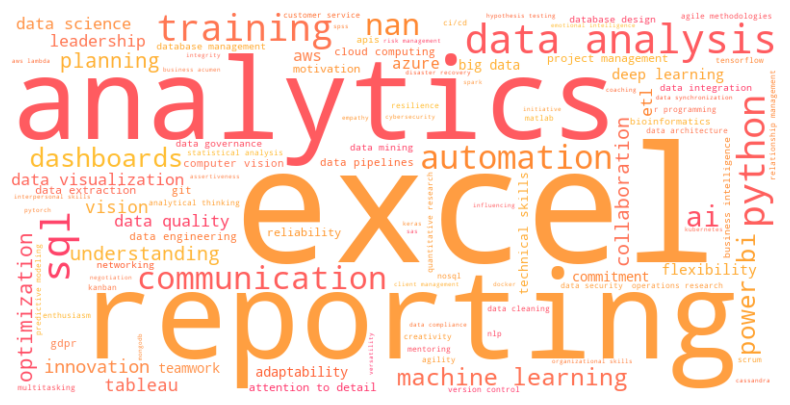

In [366]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

keywords_df['keyword'] = keywords_df['keyword'].astype(str)
flat_df = keywords_df.dropna(subset=['keyword'])

keyword_counts = Counter(keywords_df['keyword'])
# Ensure all keywords are strings and drop NaN values

cmap = LinearSegmentedColormap.from_list("mycmap", ["#FF5733", "#ffbe32", "#ff3273"])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cmap).generate_from_frequencies(keyword_counts)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# # Print the most recurrent keywords
# most_recurrent_keywords = keyword_counts.most_common()
# print("\nMost Recurrent Keywords:")
# for keyword, count in most_recurrent_keywords:
#     print(f"{keyword}: {count}")

In [304]:
keyword_counts

Counter({'excel': 115,
         'reporting': 59,
         'analytics': 50,
         'data analysis': 49,
         'sql': 47,
         'python': 43,
         'training': 41,
         'automation': 33,
         'communication': 32,
         'ai': 27,
         'dashboards': 22,
         'power bi': 21,
         'machine learning': 20,
         'optimization': 14,
         'planning': 14,
         'collaboration': 13,
         'understanding': 13,
         'innovation': 12,
         'vision': 11,
         'tableau': 11,
         'data science': 10,
         'data quality': 10,
         'data visualization': 10,
         'aws': 10,
         'etl': 10,
         'leadership': 10,
         'azure': 9,
         'deep learning': 8,
         'flexibility': 8,
         'big data': 7,
         'commitment': 7,
         'teamwork': 7,
         'adaptability': 7,
         'technical skills': 6,
         'data extraction': 5,
         'project management': 5,
         'attention to detail': 5,
       

In [330]:
test20 = detailed_jobs_df.head(20)
test20 = test20.drop(columns='keywords')

### Next steps: Building a web app with flask 
This notebook has helped understanding the basics of web scrapping. It was so much fun and, I believe, a helpful product. This is why I am going to build a web app to hold this code. So everyone in the data world can check the main key skills companies are looking for. 

So, keep an eye on my portfolio! 